#Tutorial overview

L'obiettivo di questo tutorial è quello di mostrare come si costruisce una semplice pipeline di machine learning, partendo dal caricamento dati fino al training e l'inferenza di un modello.

## Tematiche
In questo tutorial vedremo:
* Download e processing dei dati;
* Design e training di una rete neurale tramite l'utilizzo di Keras;
* Visualizzazione del training del modello.

## Caso d'uso
Il **caso d'uso** su cui lavoreremo si basa sul [United States Census Income
Dataset](https://archive.ics.uci.edu/ml/datasets/census+income), fornito dalla [UC Irvine Machine Learning
Repository](https://archive.ics.uci.edu/ml/index.php). Questo dataset contiene una porzione dei dati (anonimizzati) del censimento americano del 1994. Per ciascuna persona, include informazioni quali: età, educazione, stato sociale, occupazione e il guadagno dell'anno.

L'**obiettivo** sarà quello di costruire e allenare, tramite l'utilizzo di **Keras**, una rete neurale profonda (Deep Neural Network, DNN) che predica qualora una persona abbia un guadagno minore o maggiore di $50,000 all'anno (**target label**) basandoci sulle altre informazioni delle persone (**features**).

*Disclaimer: l'obiettivo di questo tutorial è esclusivamente quello di mostrare tecniche per lo sviluppo di modelli di Machine Learning a scopo didattico. L'autore non si assume responsabilità riguardo le problematiche di fairness che sorgono dall'utilizzo del dataset sopra descritto.*

# Import librerie e definizione costanti

First, import Python libraries required for training:

In [ ]:
import os
from six.moves import urllib
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf

print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

# Dataset

In questa sezione creiamo una data pipeline per scaricare i dati, processarli, standardizzarli e riportarli in un formato che sia utilizzabile dalla nostra rete neurale.

Download URL e gestione dei path del dataset.

In [ ]:
DATA_DIR = './sample_data/census_data'
DATA_URL = 'https://storage.googleapis.com/cloud-samples-data/ai-platform/census/data'
TRAINING_FILE = 'adult.data.csv'
EVAL_FILE = 'adult.test.csv'
TRAINING_URL = '%s/%s' % (DATA_URL, TRAINING_FILE)
EVAL_URL = '%s/%s' % (DATA_URL, EVAL_FILE)

Informazioni sulle colonne del dataset.

In [ ]:
_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'gender',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

_LABEL_COLUMN = 'income_bracket'

_CATEGORICAL_TYPES = {
    'workclass': pd.api.types.CategoricalDtype(categories=[
        'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
        'Self-emp-not-inc', 'State-gov', 'Without-pay'
    ]),
    'marital_status': pd.api.types.CategoricalDtype(categories=[
        'Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'
    ]),
    'occupation': pd.api.types.CategoricalDtype([
        'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
        'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
        'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
        'Sales', 'Tech-support', 'Transport-moving'
    ]),
    'relationship': pd.api.types.CategoricalDtype(categories=[
        'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried',
        'Wife'
    ]),
    'race': pd.api.types.CategoricalDtype(categories=[
        'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'
    ]),
    'native_country': pd.api.types.CategoricalDtype(categories=[
        'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic',
        'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece',
        'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 
        'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland',
        'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand',
        'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia'
    ]),
    'income_bracket': pd.api.types.CategoricalDtype(categories=[
        '<=50K', '>50K'
    ])
}

### Iperparametri per il training ###

# Batch size, ovvero quanti esempi vogliamo utilizzare per ogni training step
BATCH_SIZE = 128

# Numero di epoche, ovvero il massimo numero di passaggi sull'intero dataset di training
NUM_EPOCHS = 20

# Learning rate
LEARNING_RATE = .01

## Data Loading
Creiamo la funzione per scaricare il dataset e riportarli in un formato utile per il preprocessing.

In [ ]:
def _download_and_clean_file(filename, url):
    """
    Scarica i dati dall'URL e li modifica in modo da coincidere col formato CSV.
    Args:
      filename: filename dove salvare i dati
      url: URL della risorsa da cui scaricare i dati
    """
    temp_file, _ = urllib.request.urlretrieve(url)
    with tf.io.gfile.GFile(temp_file, 'r') as temp_file_object:
        with tf.io.gfile.GFile(filename, 'w') as file_object:
            for line in temp_file_object:
                line = line.strip()
                line = line.replace(', ', ',')
                if not line or ',' not in line:
                    continue
                if line[-1] == '.':
                    line = line[:-1]
                line += '\n'
                file_object.write(line)
    tf.io.gfile.remove(temp_file)


def download(data_dir):
    """Scarica il dataset se non è già presente.
    Args:
      data_dir: directory dalla quale avremo accesso al dataset
    """
    tf.io.gfile.makedirs(data_dir)

    training_file_path = os.path.join(data_dir, TRAINING_FILE)
    if not tf.io.gfile.exists(training_file_path):
        _download_and_clean_file(training_file_path, TRAINING_URL)

    eval_file_path = os.path.join(data_dir, EVAL_FILE)
    if not tf.io.gfile.exists(eval_file_path):
        _download_and_clean_file(eval_file_path, EVAL_URL)

    return training_file_path, eval_file_path

In [ ]:
training_file_path, eval_file_path = download(DATA_DIR)

# Se è andato a buon fine, dovrebbe mostrare i files adult.data.csv and adult.test.csv
!ls -l $DATA_DIR

Carichiamo i dati in un Pandas Dataframe e diamo una prima occhiata.

In [ ]:
train_df = pd.read_csv(training_file_path, names=_CSV_COLUMNS, na_values='?')
eval_df = pd.read_csv(eval_file_path, names=_CSV_COLUMNS, na_values='?')

# Questo è il modo in cui appaiono i dati prima della fase di preprocessing
train_df.head()

## Preprocessing

Il preprocessing è una fase chiave di qualsiasi pipeline di Machine Learning: i dati devono sempre essere puliti, riscalati e resi fruibili per il modello di ML che vogliamo utilizzare. 

Ricordate il mantra di chiunque faccia analisi dati: garbage-in ➡ garbage-out. 😀

### Cleaning

Qualsiasi dataset deve passare sempre da una fase di cleaning in cui dobbiamo trattare eventuali valori mancanti, decidere se mantenere gli outliers e scegliere le features utili.

In questo caso, possiamo limitarci tratteniamo esclusivamente le colonne utili. Cosa significa "utili"? E perché?

In [ ]:
UNUSED_COLUMNS = ['fnlwgt', 'education', 'gender']

def cleaning(dataframe):
    """
    Rimuove le colonne superflue e codifica i valori categorici.
    Args:
      dataframe: Pandas dataframe con i dati grezzi
    Returns:
      Dataframe con i dati puliti
    """
    return dataframe.drop(columns=UNUSED_COLUMNS)


In [ ]:
train_df = cleaning(train_df)
eval_df = cleaning(eval_df)
train_df.head()

### Codifica dei campi a valori numerici

Il dataset deve essere restituito in un formato che sia utilizzabile da una rete neurale, ossia numerico.

Nel caso dei **valori numerici**, bisogna effettuare una banale conversione a `float32`.

I **valori categorici**, invece, sono definiti come insiemi discreti dove gli elementi definiscono una certa categoria (in senso lato). \\
La prassi è assegnare a ciascun elemento dell'insieme un codice che lo identifichi univocamente al suo interno.

Esempio: `frutta = {mela, pera, banana}` ➡ `frutta = {0, 1, 2}` con `mela=0`, `pera=1`, `banana=2`.

In [ ]:
def columns_to_numeric(dataframe):
    # Convertiamo i valori numerici a float32.
    numeric_columns = dataframe.select_dtypes(['int64']).columns
    dataframe[numeric_columns] = dataframe[numeric_columns].astype('float32')

    # Conversione dei valori categorici a numerici.
    cat_columns = dataframe.select_dtypes(['object']).columns
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.astype(_CATEGORICAL_TYPES[x.name]))
    dataframe[cat_columns] = dataframe[cat_columns].apply(lambda x: x.cat.codes)
    return dataframe

In [ ]:
train_df = columns_to_numeric(train_df)
eval_df = columns_to_numeric(eval_df)
train_df.head()

### Rescaling

Due tra le tipologie di rescaling più utilizzate sono le seguenti:
* Standardizzazione con z-score: `(x - x_mean)/std` ;
* Min-max scaling: `(x_max - x) / (x_max - x_min)` . 

Il rescaling è una fase fondamentale di qualsiasi data pipeline. Vediamo perché nel caso delle reti neurali.

In [ ]:
def standardize(dataframe):
    """
    Riscala le colonne numeriche tramite standardizzazione con z-score.
    Args:
      dataframe: Pandas dataframe
    Returns:
      Il dataframe in input con le colonne numeriche riscalate.
    """
    dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
    # Normalizziamo le colonne numeriche.
    for column, dtype in dtypes:
        if dtype == 'float32':
            dataframe[column] -= dataframe[column].mean()
            dataframe[column] /= dataframe[column].std()
    return dataframe

Dividiamo dati di training e di validazione dal label che vogliamo predire. Il metodo `pop` copia la colonna del label e la rimuove dal dataframe.

Dopodiché, facciamo reshaping dei vettori dei label per renderli in un formato `[1 x num_samples]`, che utilizzeremo successivamente in `tf.data.Dataset`.

In [ ]:
train_x, train_y = train_df, train_df.pop(_LABEL_COLUMN)
eval_x, eval_y = eval_df, eval_df.pop(_LABEL_COLUMN)

train_y = np.asarray(train_y).astype('float32').reshape((-1, 1))
eval_y = np.asarray(eval_y).astype('float32').reshape((-1, 1))

Uniamo `train_x` ed `eval_x` per fare la normalizzazione rispetto alla media e alla deviazione standard di tutti dati. Dopodiché li separiamo nuovamente.

In [ ]:
all_x = pd.concat([train_x, eval_x], keys=['train', 'eval'])
all_x = standardize(all_x)
train_x, eval_x = all_x.xs('train'), all_x.xs('eval')
print(train_y)
train_x.head()

Bene, il nostro dataset adesso è in un formato fruibile dalla nostra rete neurale. Passiamo alla parte divertente!

# Training pipeline

La training pipeline è descritta dal seguente processo:

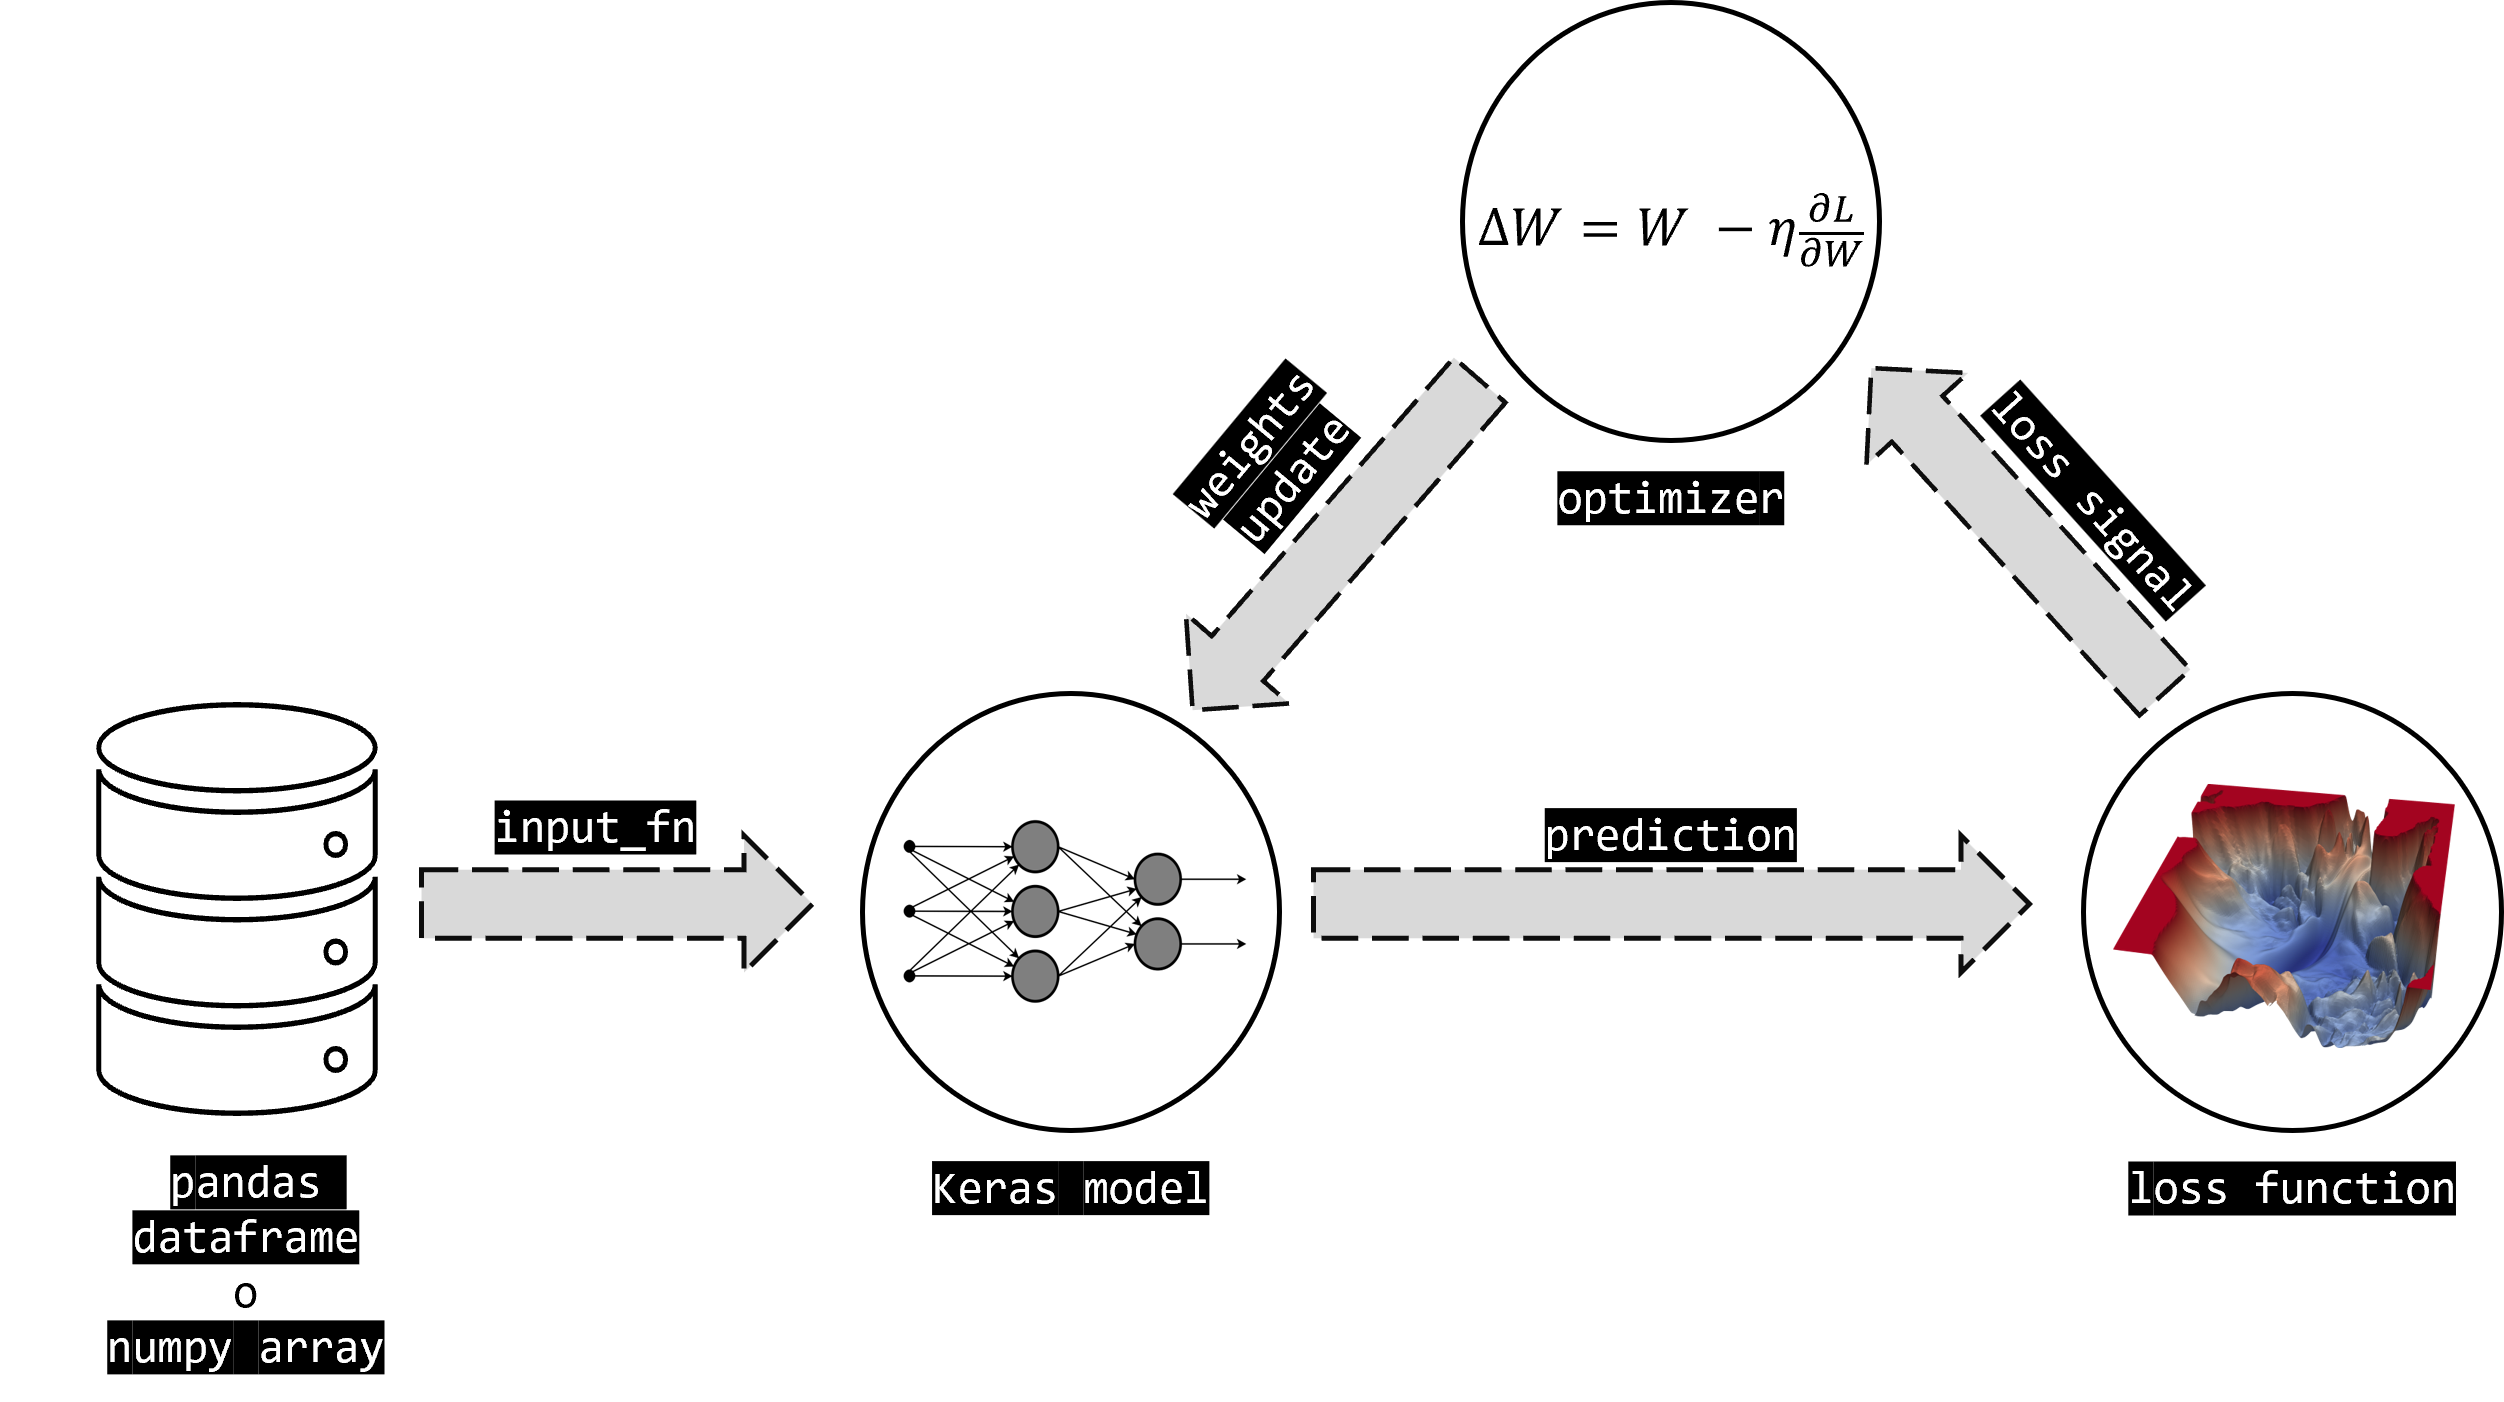

Vediamo come va implementato ciascuno step.


### Creazione dei dataset di training e validazione

Creiamo la funzione di input per convertire le features e le labels in un 
[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets) per training e validazione:

In [ ]:
def input_fn(features, labels, shuffle, num_epochs, batch_size):
    """Genera una funzione di input per il modello Keras.
    Args:
      features: numpy array delle features utilizzate per training o inferenza
      labels: numpy array delle etichette di ciascun esempio
      shuffle: booleano che determina se bisogna fare uno shuffle dei dati (True 
        per il training, False per la validazione)
      num_epochs: numero di epoche di training
      batch_size: batch size in fase di training
    Returns:
      tf.data.Dataset che può fornite i dati al Keras model per training o 
        inferenza
    """
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(features))

    # Utilizziamo la repeat dopo lo shuffle per evitare che epoche separate si 
    # mischino.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

Dopodiché, instanziamo i dataset di training e di validazione. Utilizziamo gli iperparametri `NUM_EPOCHS` e `BATCH_SIZE` definiti precedentemente per definire il modo in cui questi dataset devono fornire gli esempi durante il training loop. Settiamo il dataset di validazione così da fargli fornire tutti gli esempi in un solo step. In questo modo, la validazione viene fatta in un singolo step alla fine di ogni epoca di training.

In [ ]:
# Passiamo un numpy array alle features utilizzando il metodo del Dataframe .values
training_dataset = input_fn(features=train_x.values, 
                    labels=train_y, 
                    shuffle=True, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE)

num_eval_examples = eval_x.shape[0]

validation_dataset = input_fn(features=eval_x.values, 
                    labels=eval_y, 
                    shuffle=False, 
                    num_epochs=NUM_EPOCHS, 
                    batch_size=num_eval_examples)

##Design della Deep Neural Network tramite [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model)

Come descritto dal nome stesso dell'API, Keras Sequential API fornisce un'astrazione che permette di costruire una rete neurale come una semplice sequenza di [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

La nostra istanza di rete neurale ha diversi hidden layers, e l'ultimo utilizza la sigmoide come funzione di attivazione e fornisce in output un valore tra 0 e 1. In particolare:
* Il layer di input ha 100 unità e utilizza la ReLU come funzione di attivazione;
* Il primo hidden layer ha 100 unità e utilizza la ReLU come funzione di attivazione;
* Il secondo hidden layer ha 75 unità e utilizza la ReLU come funzione di attivazione;
* Il terzo hidden layer ha 50 unità e utilizza la ReLU come funzione di attivazione;
* Il quarto hidden layer ha 25 unità e utilizza la ReLU come funzione di attivazione;
* Il layer di output ha 1 unità e utilizza la sigmoide come funzione di attivazione.


In [ ]:
def create_keras_model(input_dim):
    """Crea un modello Keras per classificazione binaria.
    Args:
      input_dim: il numero di features dell'input (ovvero il numero di colonne del dataframe)
    Returns:
      Keras model
    """
    Dense = tf.keras.layers.Dense
    model = tf.keras.Sequential(
        [
            Dense(100, activation=tf.nn.relu, kernel_initializer='uniform',
                  input_shape=(input_dim,)),
            Dense(75, activation=tf.nn.relu),
            Dense(50, activation=tf.nn.relu),
            Dense(25, activation=tf.nn.relu),
            Dense(1, activation=tf.nn.sigmoid)
        ])

    return model
    

Creiamo il modello Keras ed esaminiamo la sua struttura:

In [ ]:
num_train_examples, input_dim = train_x.shape
print('Number of features: {}'.format(input_dim))
print('Number of examples: {}'.format(num_train_examples))

model = create_keras_model(input_dim=input_dim)

# Diamo un'occhiata dettagliata al modello
model.summary()

## Design dell'ottimizzatore

L'ottimizzatore rappresenta la cosiddetta *update rule* tramite la quale, ad ogni step di training, aggiorniamo i pesi del modello. In questa fase le scelte da fare sono le seguenti:
* Scegliere la funzione di **loss** da utilizzare, ovvero la funzione che valuta il livello di errore che sta commettendo la rete nelle predizioni. In questo caso utilizziamo la binary cross-entropy, che è la più indicata per task di classificazione binaria;
* Scegliere il tipo di ottimizzatore. In questo caso, RMSProp;
* Scegliere gli iperparametri dell'ottimizzatore. Qui, esclusivamente il learning rate e i parametri di decay del learning rate.

A questo punto, creiamo anche l'ottimizzatore e lo linkamo al modello tramite il metodo `model.compile`:

In [ ]:
def link_optimizer(model, learning_rate):
    '''
    Crea un ottimizzatore e compila il modello.
    Args:
      model: il Keras model a cui dobbiamo linkare l'ottimizzatore
      learning_rate: il learning rate dell'ottimizzatore
    Returns:
      il Keras model compilato
    '''
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compiliamo il modello Keras model
    model.compile(
        loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
model = link_optimizer(model=model, learning_rate=LEARNING_RATE)

Definiamo la funzione che fa decadere il learning rate man mano che si avanza nel training:

In [ ]:
def learning_rate_decay_callback():
  lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: LEARNING_RATE + 0.02 * (0.5 ** (1 + epoch)),
      verbose=True)
  return lr_decay_cb

In [ ]:
lr_decay_cb = learning_rate_decay_callback()

Infine, possiamo avviare il training del modello. Dobbiamo fornire il valore appropriato di `steps_per_epoch` per il modello per far sì che un'epoca prenda l'intero dataset di training (con `BATCH_SIZE` esempi per step). Alla fine di ogni epoca di training, il modello calcola l'accuratezza in fase di validazione sull'intero dataset di validazione.

In [ ]:
history = model.fit(training_dataset, 
                    epochs=NUM_EPOCHS, 
                    steps_per_epoch=int(num_train_examples/BATCH_SIZE), 
                    validation_data=validation_dataset, 
                    validation_steps=1, 
                    callbacks=[lr_decay_cb],
                    verbose=1)

# Visualizzazione dei risultati

Il modello è arrivato a convergenza, ma vediamo come si è comportato tramite l'utilizzo della libreria `matplotlib`.

In [ ]:
from matplotlib import pyplot as plt

Generiamo un primo grafico per visualizzare il comportamento della funzione di loss durante il training.

In [ ]:
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Il secondo grafico permette di visualzzare l'accuratezza del modello in training.

In [ ]:
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()